# Dynamic mode decomposition of PDE systems
We apply dynamic mode decomposition (DMD) to several PDE systems from J. Nathan Kutz,
J. L. Proctor, and S. L. Brunton,
“Applied Koopman Theory for Partial Differential Equations and Data-Driven
Modeling of Spatio-Temporal Systems,” Complexity, vol. 2018, no. ii, pp. 1–16, 2018.):

- 1D viscous Burgers equation
- 1D nonlinear schrodinger equation
- 1D cubic-quintic Ginzburg-Landau equation

We first import the pyKoopman package and other packages for plotting and matrix manipulation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

import pykoopman as pk

# 1. Viscous Burgers equation

$$
u_t + u u_x = \nu u_{xx}
$$
where periodic boundary condition is used on $[-15,15]$. Initial condition follows 
$u(x,0)=e^{-(x+2)^2}$.


In [2]:
from pykoopman.common import vbe

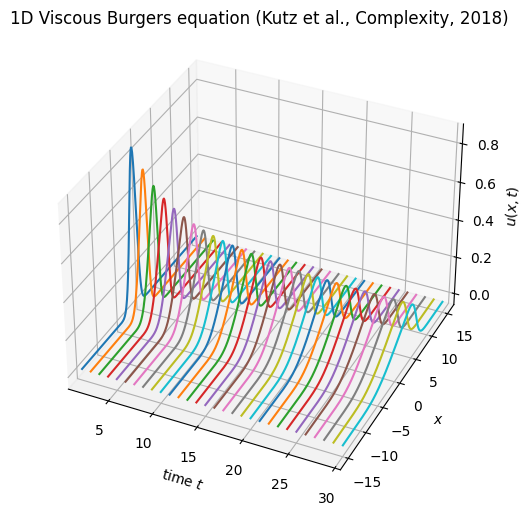

data shape =  (30, 256)


In [3]:
n = 256
x = np.linspace(-15, 15, n, endpoint=False)
u0 = np.exp(-(x+2)**2)
# u0 = 2.0 / np.cosh(x)
# u0 = u0.reshape(-1,1)
n_int = 3000
n_snapshot = 30
dt = 30. / n_int
n_sample = n_int // n_snapshot

model_vbe = vbe(n, x, dt=dt, L=30)
X, t = model_vbe.simulate(u0, n_int, n_sample)
delta_t = t[1]-t[0]

model_vbe.visualize_data(x, t, X)


print("data shape = ",X.shape)

In [4]:
from pydmd import DMD

dmd=DMD(svd_rank=5)
model = pk.Koopman(regressor=dmd)
model.fit(X, dt=delta_t)

Koopman(observables=Identity(),
        regressor=PyDMDRegressor(regressor=<pydmd.dmd.DMD object at 0x7fdd48b4dcc0>))

## check spectrum

Text(0, 0.5, '$Im(\\lambda)$')

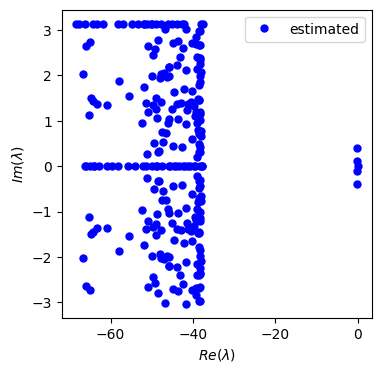

In [5]:
K = model.koopman_matrix

# Let's have a look at the eigenvalues of the Koopman matrix
evals, evecs = np.linalg.eig(K)
evals_cont = np.log(evals)/delta_t

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(evals_cont.real, evals_cont.imag, 'bo', label='estimated',markersize=5)


# ax.set_xlim([-0.1,1])
# ax.set_ylim([2,3])
plt.legend()
plt.xlabel(r'$Re(\lambda)$')
plt.ylabel(r'$Im(\lambda)$')
# print(omega1,omega2)

## check prediction

In [6]:
def plot_pde_dynamics(x, t, X, X_pred, title_list):
    fig = plt.figure(figsize=(12, 8))
    
    ax = fig.add_subplot(131, projection='3d')
    # ax = plt.axes(projection='3d')
    for i in range(X.shape[0]):
        ax.plot(x, X[i], zs=t[i], zdir='t')
    # plt.legend(loc='best')
    ax.view_init(elev=35., azim=-65, vertical_axis='y')
    ax.set(ylabel=r'$u(x,t)$', xlabel=r'$x$', zlabel=r'time $t$')
    plt.title(title_list[0])

    ax = fig.add_subplot(132, projection='3d')
    # ax = plt.axes(projection='3d')
    for i in range(X_predicted.shape[0]):
        ax.plot(x, X_pred[i], zs=t[i], zdir='t')
    # plt.legend(loc='best')
    ax.view_init(elev=35., azim=-65, vertical_axis='y')
    ax.set(ylabel=r'$u(x,t)$', xlabel=r'$x$', zlabel=r'time $t$')
    plt.title(title_list[1])
    
    ax = fig.add_subplot(133, projection='3d')
    # ax = plt.axes(projection='3d')
    for i in range(X_predicted.shape[0]):
        ax.plot(x, (X_pred-X)[i], zs=t[i], zdir='t')
    # plt.legend(loc='best')
    ax.view_init(elev=35., azim=-65, vertical_axis='y')
    ax.set(ylabel=r'$u(x,t)$', xlabel=r'$x$', zlabel=r'time $t$')
    plt.title(title_list[2])

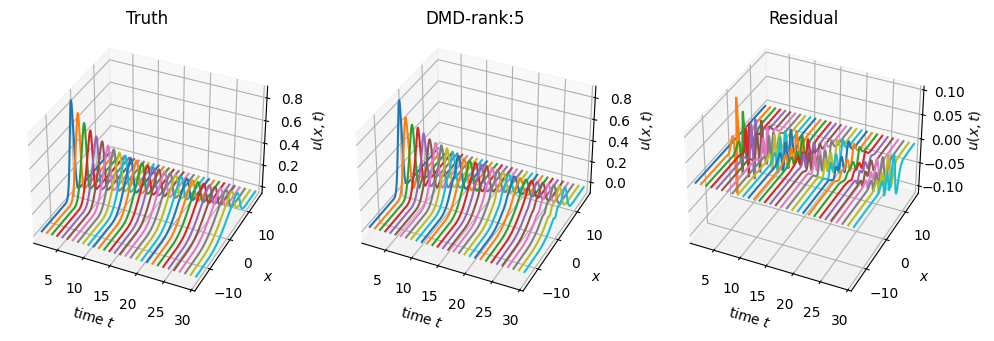

In [7]:
X_predicted = np.vstack((X[0], model.simulate(X[0], n_steps=X.shape[0] - 1)))
plot_pde_dynamics(x,t,X, X_predicted, ['Truth','DMD-rank:'+str(model.reduced_state_transition_matrix.shape[0]),'Residual'])

# 2. nonlinear schrodinger equation

$$iu_t + 0.5u_{xx} + u|u|^2 = 0$$
periodic boundary condition in $[-15,15]$ with initial condition as 
$2.0 / \cosh(x)$

In [8]:
from pykoopman.common import nlse

In [9]:
n = 512
x = np.linspace(-15, 15, n, endpoint=False)
u0 = 2.0 / np.cosh(x)
# u0 = u0.reshape(-1,1)
n_int = 10000
n_snapshot = 80  # in the original paper, it is 20, but I think too small
dt = np.pi / n_int
n_sample = n_int // n_snapshot


model = nlse(n, dt=dt, L=30)
X, t = model.simulate(u0, n_int, n_sample)

delta_t = t[1] - t[0]

NameError: name 'dt' is not defined

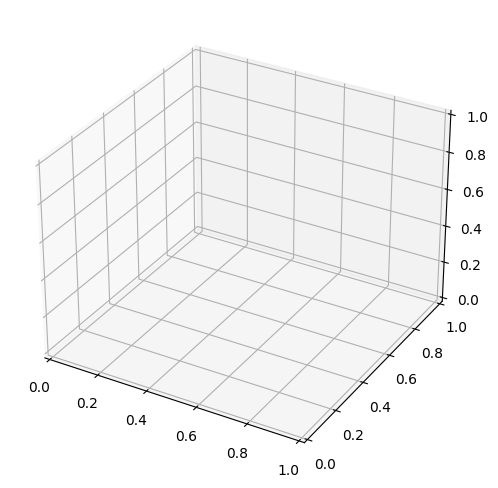

In [78]:
model.visualize_data(x,t,X)

Define helper function, hyperbolic secant

In [3]:
def sech(x):
    return 1./np.cosh(x)

Generate training data from two spatiotemporal signals

In [4]:
omega1 = 2.3
omega2 = 2.8
f1 = np.multiply(sech(Xgrid+3), np.exp(1j*omega1*Tgrid))
f2 = np.multiply( np.multiply(sech(Xgrid), np.tanh(Xgrid)), 2*np.exp(1j*omega2*Tgrid))
f = f1 + f2

In [5]:
def plot_dynamics(Xgrid, Tgrid, f, fig=None, title='', subplot=111):
    if fig is None:
        fig = plt.figure(figsize=(12, 4))

    time_ticks = np.array([0, 1*np.pi, 2*np.pi, 3*np.pi, 4*np.pi])
    time_labels = ('0', r'$\pi$', r'$2\pi$', r'$3\pi$', r'$4\pi$')

    ax = fig.add_subplot(subplot, projection='3d')
    surf = ax.plot_surface(Xgrid, Tgrid, f, rstride=1)
    cset = ax.contourf(Xgrid, Tgrid, f, zdir='z', offset=-1.5, cmap=cm.ocean)
    ax.set(
        xlabel=r'$x$',
        ylabel=r'$t$',
        title=title,
        yticks=time_ticks,
        yticklabels=time_labels,
        xlim=(-10, 10),
        zlim=(-1.5, 1),
    )
    ax.autoscale(enable=True, axis='y', tight=True)

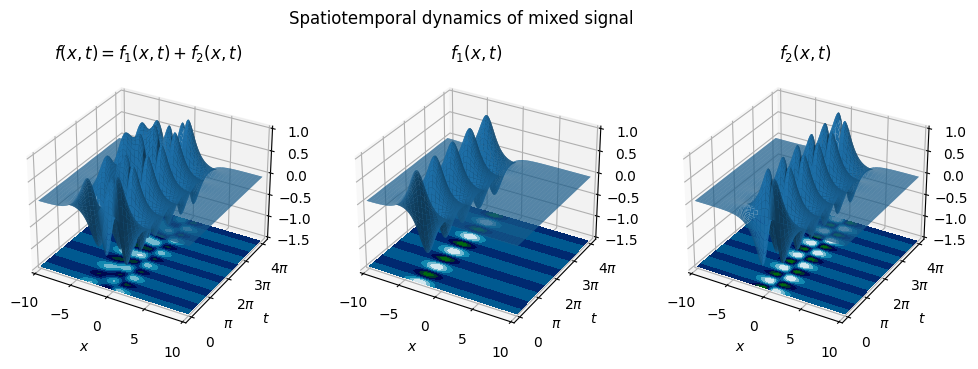

In [6]:
fig = plt.figure(figsize=(12,4))
fig.suptitle('Spatiotemporal dynamics of mixed signal')

plot_dynamics(Xgrid, Tgrid, f, fig=fig, title=r'$f(x, t) = f_1(x,t) + f_2(x,t)$', subplot=131)
plot_dynamics(Xgrid, Tgrid, f1, fig=fig, title=r'$f_1(x,t)$', subplot=132)
plot_dynamics(Xgrid, Tgrid, f2, fig=fig, title=r'$f_2(x,t)$', subplot=133)

Instantiate and fit a Koopman model using DMD on training data

In [7]:
from pydmd import DMD

dmd=DMD(svd_rank=2)

model = pk.Koopman(regressor=dmd)
model.fit(f, dt=dt)

Koopman(observables=Identity(),
        regressor=PyDMDRegressor(regressor=<pydmd.dmd.DMD object at 0x7f1d8ec1ab30>))

Text(0, 0.5, '$Im(\\lambda)$')

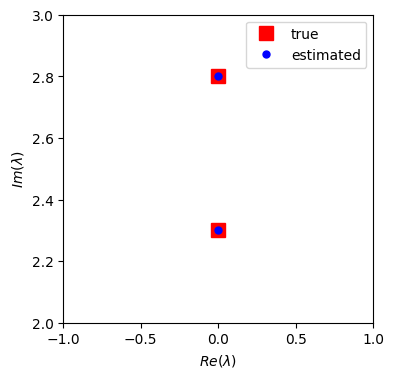

In [12]:
K = model.koopman_matrix

# Let's have a look at the eigenvalues of the Koopman matrix
evals, evecs = np.linalg.eig(K)
evals_cont = np.log(evals)/dt

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot([0,0], [omega1,omega2],'rs', label='true',markersize=10)
ax.plot(evals_cont.real, evals_cont.imag, 'bo', label='estimated',markersize=5)


ax.set_xlim([-1,1])
ax.set_ylim([2,3])
plt.legend()
plt.xlabel(r'$Re(\lambda)$')
plt.ylabel(r'$Im(\lambda)$')
# print(omega1,omega2)

Check if model can reconstruct the training data by predicting starting from the first snapshot.

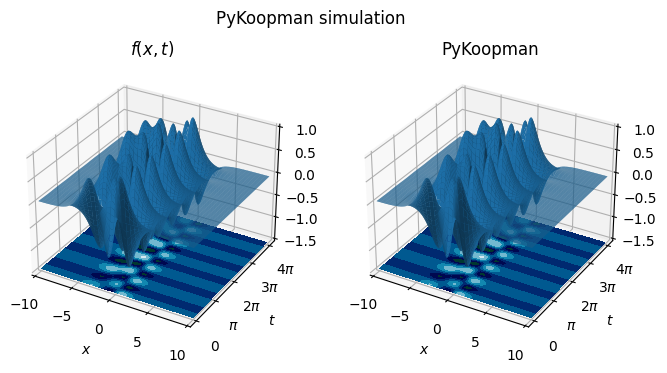

In [9]:
f_predicted = np.vstack((f[0], model.simulate(f[0], n_steps=f.shape[0] - 1)))

fig = plt.figure(figsize=(8, 4))
fig.suptitle('PyKoopman simulation')

plot_dynamics(Xgrid, Tgrid, f, fig=fig, title=r'$f(x, t)$', subplot=121)
plot_dynamics(Xgrid, Tgrid, f_predicted, fig=fig, title='PyKoopman', subplot=122)